# Deep Hedging AI
### Recurrent Network: impact of using recurrent networks on hedging barrier options. In this example, Deep Hedging does mot learn anything - which is superior to using Black & Scholes.

Hans Buehler, January 2023


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.10" "tensorflow_probability==0.14"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

Deep Hedging AI says hello ... Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


## Plotting payoff KO Put k=1, b=0.95

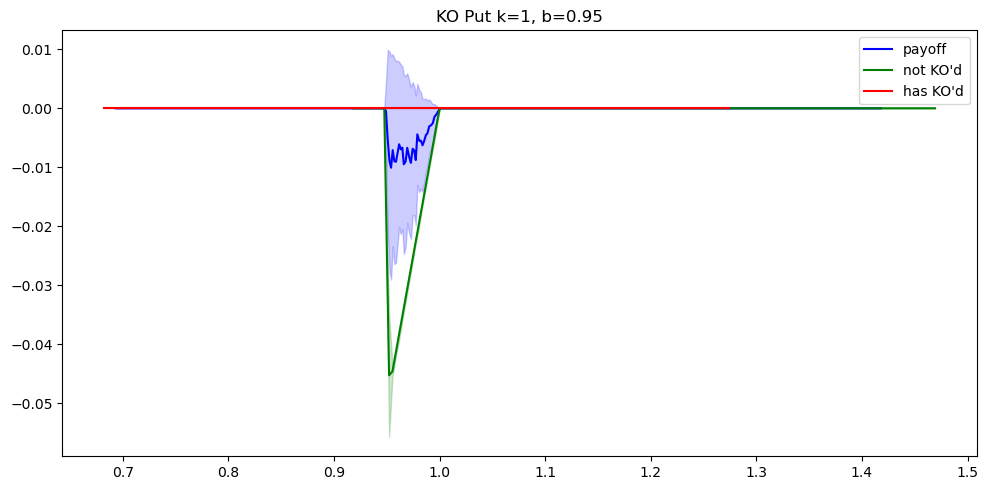

In [2]:
print("Deep Hedging AI says hello ... ", end='')

import importlib as imp
import deephedging.agents as _
imp.reload(_)

from cdxbasics.config import Config
from cdxbasics.prettydict import PrettyOrderedDict as pdct
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
from cdxbasics.dynaplot import figure, colors_tableau
import numpy as np
from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.steps = 20
#config.world.dt    = 1./50.
iReset = 10

nBins = 200

strike  = 1.
barrier = 0.95
def payoff_def( spots ):
    notko      = np.cumprod( np.where( spots[:,:] > barrier, 1., 0. ), axis=1 )
    terminal   = np.maximum( 1. - spots[:,-1], 0. )  # put
    return dict( payoff=-terminal*notko[:,-1],
                 features=notko[:,:-1] )
payoff_def.name = "KO Put k=%g, b=%g" % (strike, barrier)

config.world.samples = 20000
config.world.drift = 0.
config.world.cost_s = 0.
config.world.black_scholes = True
config.world.payoff = payoff_def
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.01
config.gym.agent.network.depth = 5
config.gym.agent.network.width = 50
config.gym.agent.network.activation = "softplus"
config.gym.agent.recurrence.states.classic   = 1
config.gym.agent.recurrence.states.aggregate = 1
config.gym.agent.recurrence.states.past_repr = 1
config.gym.agent.recurrence.states.event     = 1
config.gym.agent.features = ['price', 'delta', 'time_left', 'payoff_features']
#
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 0.9
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 250
config.trainer.caching.mode = "on"
config.trainer.caching.epoch_freq = 100
config.trainer.visual.epoch_refresh = 20
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75
config_ref = config.copy()  # create unused copy

# create world
world      = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//2)

# plot
# ----

display(Markdown("## Plotting payoff " + payoff_def.name))
from deephedging.base import npCast, mean_bins
from cdxbasics.dynaplot import figure, colors_base
import numpy as np

payoff = world.data.market.payoff
spots  = world.details.spot_all
notko  = world.data.features.per_step.payoff_features
ref    = spots[:,-1]
ixs    = np.argsort(ref)
nko_s  = notko[ixs,-1]
ref_s  = ref[ixs]
pyo_s  = payoff[ixs]
colors = colors_base()

fig = figure(col_size=10,col_nums=1)
ax = fig.add_subplot()
ax.set_title("%s" % payoff_def.name)

xm   = mean_bins( ref_s, bins=nBins, weights=world.sample_weights, return_std = False )
m, s = mean_bins( pyo_s, bins=nBins, weights=world.sample_weights, return_std = True )
col  = next(colors)
ax.plot( xm, m, color=col, label="payoff")
ax.fill_between( xm, m-s,m+s, color=col,alpha=0.2)

xm   = mean_bins( ref_s[nko_s > 0.], bins=nBins, weights=world.sample_weights, return_std = False )
m, s = mean_bins( pyo_s[nko_s > 0.], bins=nBins, weights=world.sample_weights, return_std = True )
col  = next(colors)
ax.plot( xm, m, color=col, label="not KO'd")
ax.fill_between( xm, m-s,m+s, color=col,alpha=0.2)

xm   = mean_bins( ref_s[nko_s < 1.], bins=nBins, weights=world.sample_weights, return_std = False )
m, s = mean_bins( pyo_s[nko_s < 1.], bins=nBins, weights=world.sample_weights, return_std = True )
col  = next(colors)
ax.plot( xm, m, color=col, label="has KO'd")
ax.fill_between( xm, m-s,m+s, color=col,alpha=0.2)

ax.legend()
fig.close()

# Create test configs
# -------------------

configs = pdct()

# not recurrent
config = config_ref.copy()
config.gym.agent.recurrence.states.classic   = 0
config.gym.agent.recurrence.states.aggregate = 0
config.gym.agent.recurrence.states.past_repr = 0
config.gym.agent.recurrence.states.event     = 0
config.world.mark_done()
configs.none = config

# digital states
config = config_ref.copy()
config.gym.agent.recurrence.states.classic   = 0
config.gym.agent.recurrence.states.aggregate = 0
config.gym.agent.recurrence.states.past_repr = 5
config.gym.agent.recurrence.states.event     = 5
config.world.mark_done()
configs.digital = config

## Hedging a KO Put k=1, b=0.95 in recurrent 'none' mode

Initializing training at 2023-02-19 15:22:37: gym with 10.5K trainable weights compiled. Took 13s
Agent is using 10502 weights: 10501 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, payoff_features, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, payoff_features, price and time_left
 Features available for initial delta: cost, ivol, lbnd_a, payoff_features, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1.01 is using 1 weight
 Features available: cost, ivol, lbnd_a, payoff_features, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ 'C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.deephedging_cache/7057f96668ba472f16403841a8b007f7453ce428149459f6.pck'
Cache successfully loaded. Current epoch: 250
Nothing to do: cached model loaded from C:/Users/

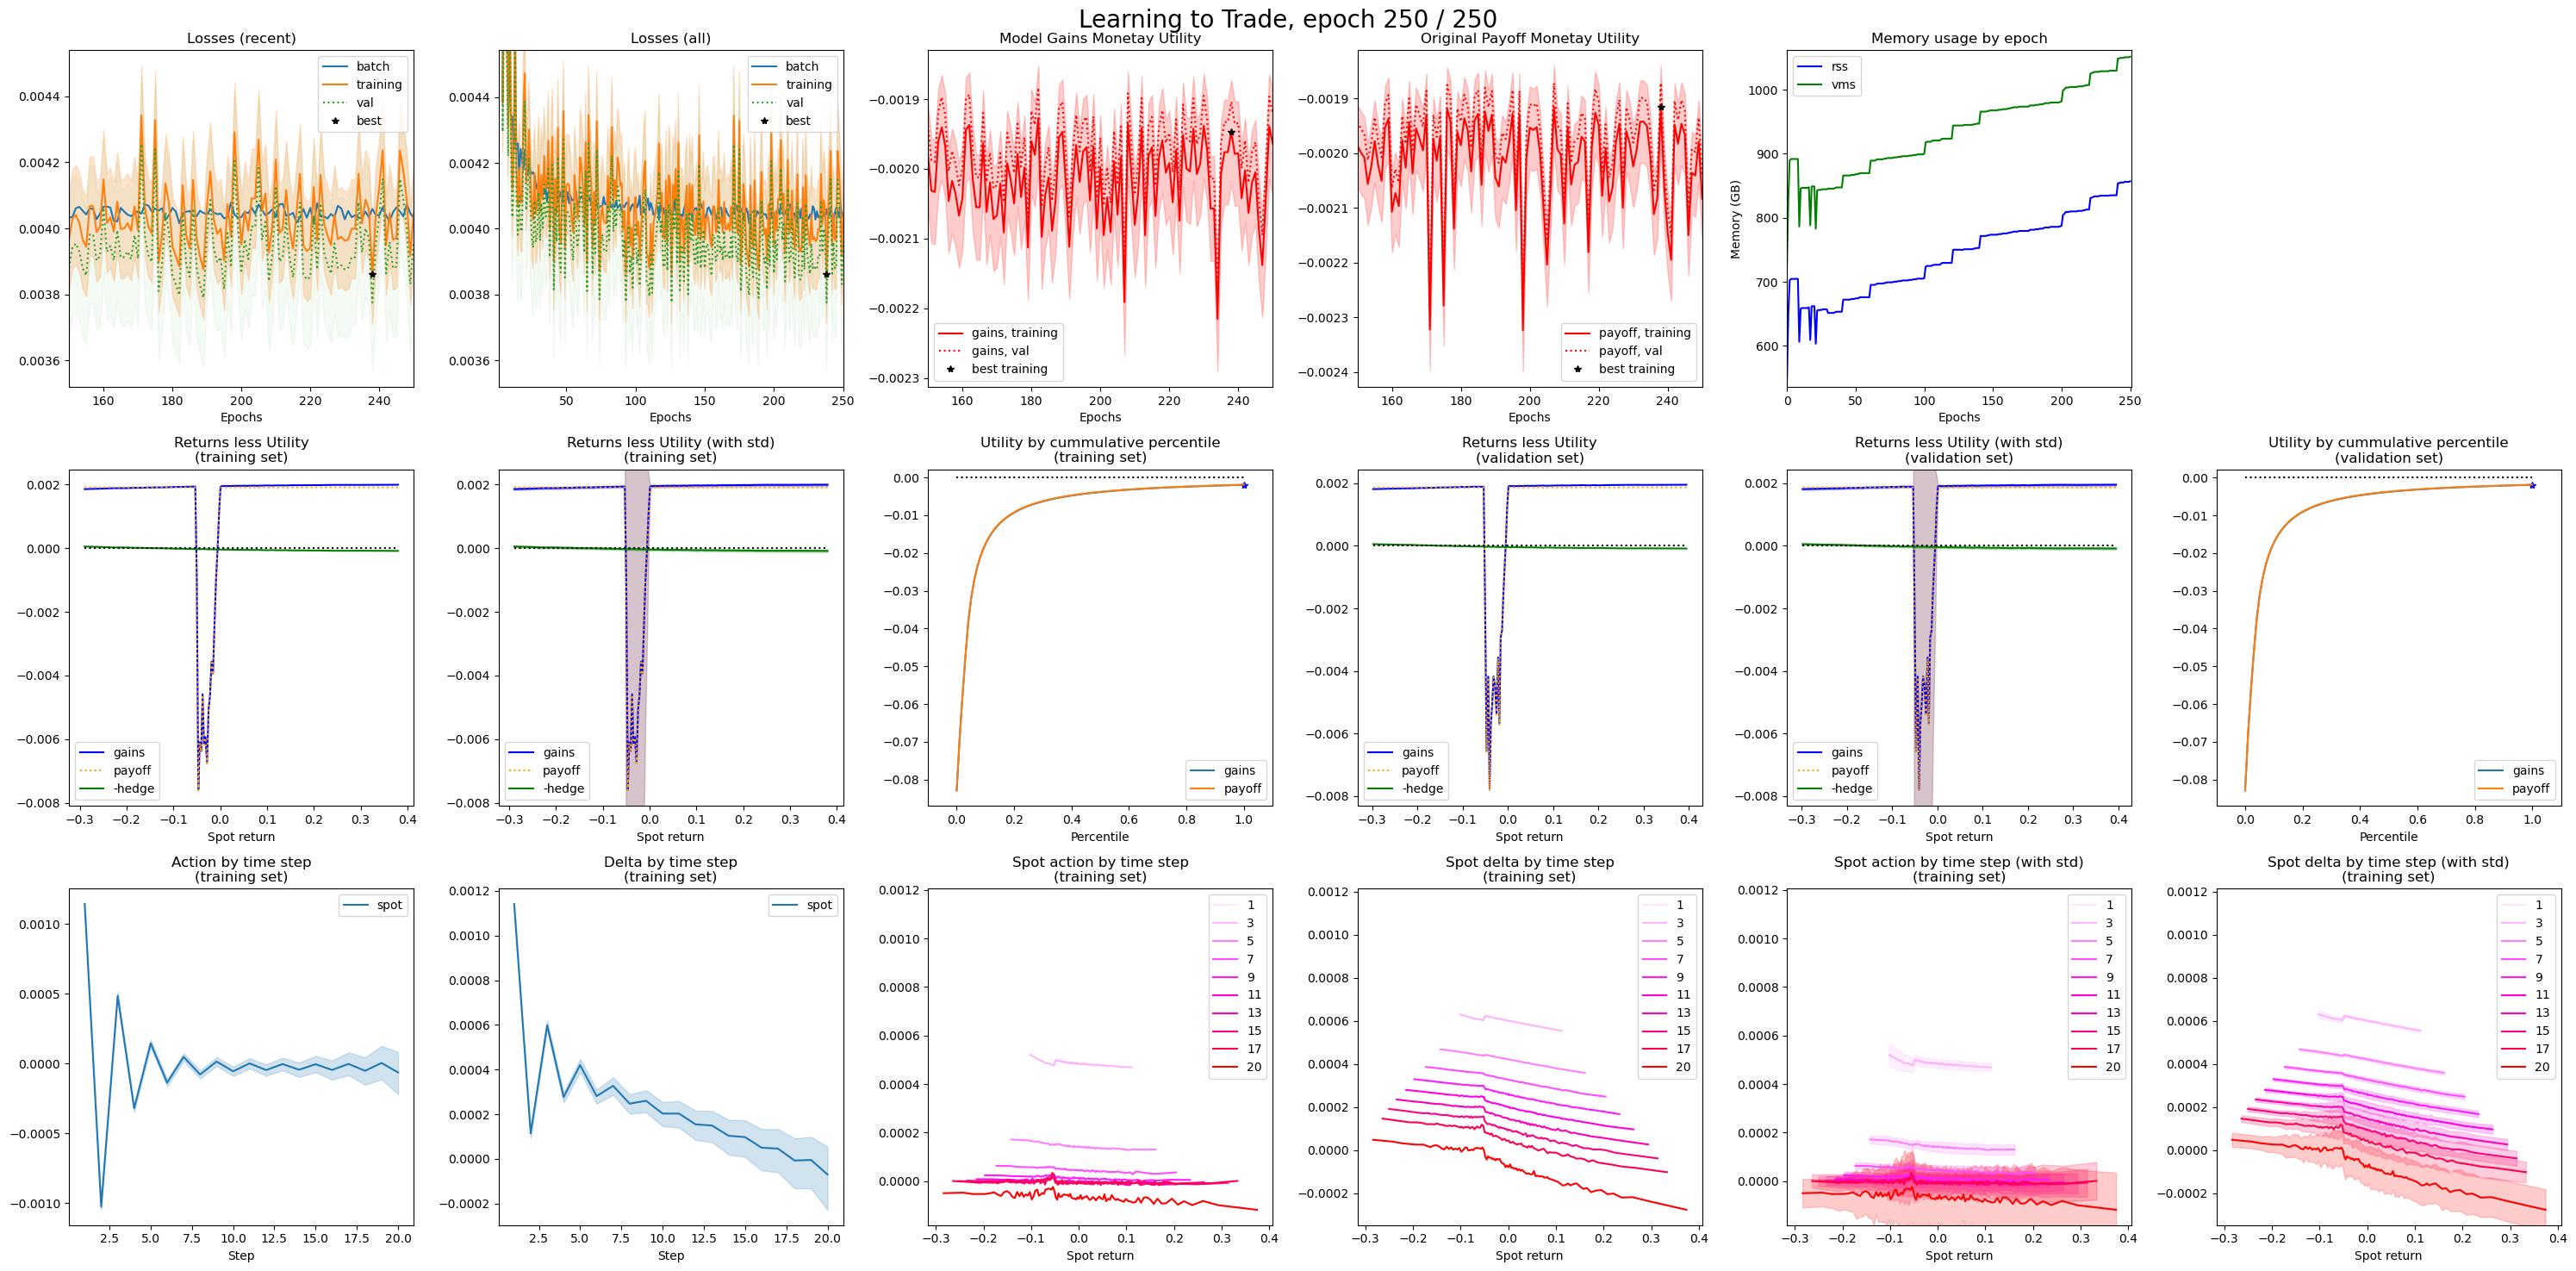

Training 250/250 epochs; 10.5K weights; 20000 samples; 10000 validation samples batch size 32 | initial loss 0.470347 (0.00521583), training 0.00404631 (0.000150418), best 0.00386217 (0.00521583), batch 0.00403219, val 0.00396001 (0.000208809); best epoch 238, last cached 250 | memory used: rss 856.992M, vms 1051.49M | time elapsed 1:14:33; time per epoch 17s; estimated time remaining 0s | current time: 2023-02-19 15:22:56                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 238
 State of training until epoch 250 cached into C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.deephedging_cache/7057f96668ba472f16403841a8b007f7453ce428149459f6.pck
 Time: 2023-02-19 15:23:05
Training terminated. Total time taken 27s


## Hedging a KO Put k=1, b=0.95 in recurrent 'digital' mode

Initializing training at 2023-02-19 15:23:11: gym with 12.03K trainable weights compiled. Took 5s
Agent is using 12032 weights: 12021 for the main agent per step, 1 for initial delta, 10 for initial states.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, payoff_features, pnl, price, recurrent_state, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, payoff_features, price, recurrent_state and time_left
 Features available for initial delta: cost, ivol, lbnd_a, payoff_features, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
 Features available for initial state: cost, ivol, lbnd_a, payoff_features, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial state:       -
Monetary utility cvar@1.01 is using 1 weight
 Features available: cost, ivol, lbnd_a, payoff_features, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ 'C

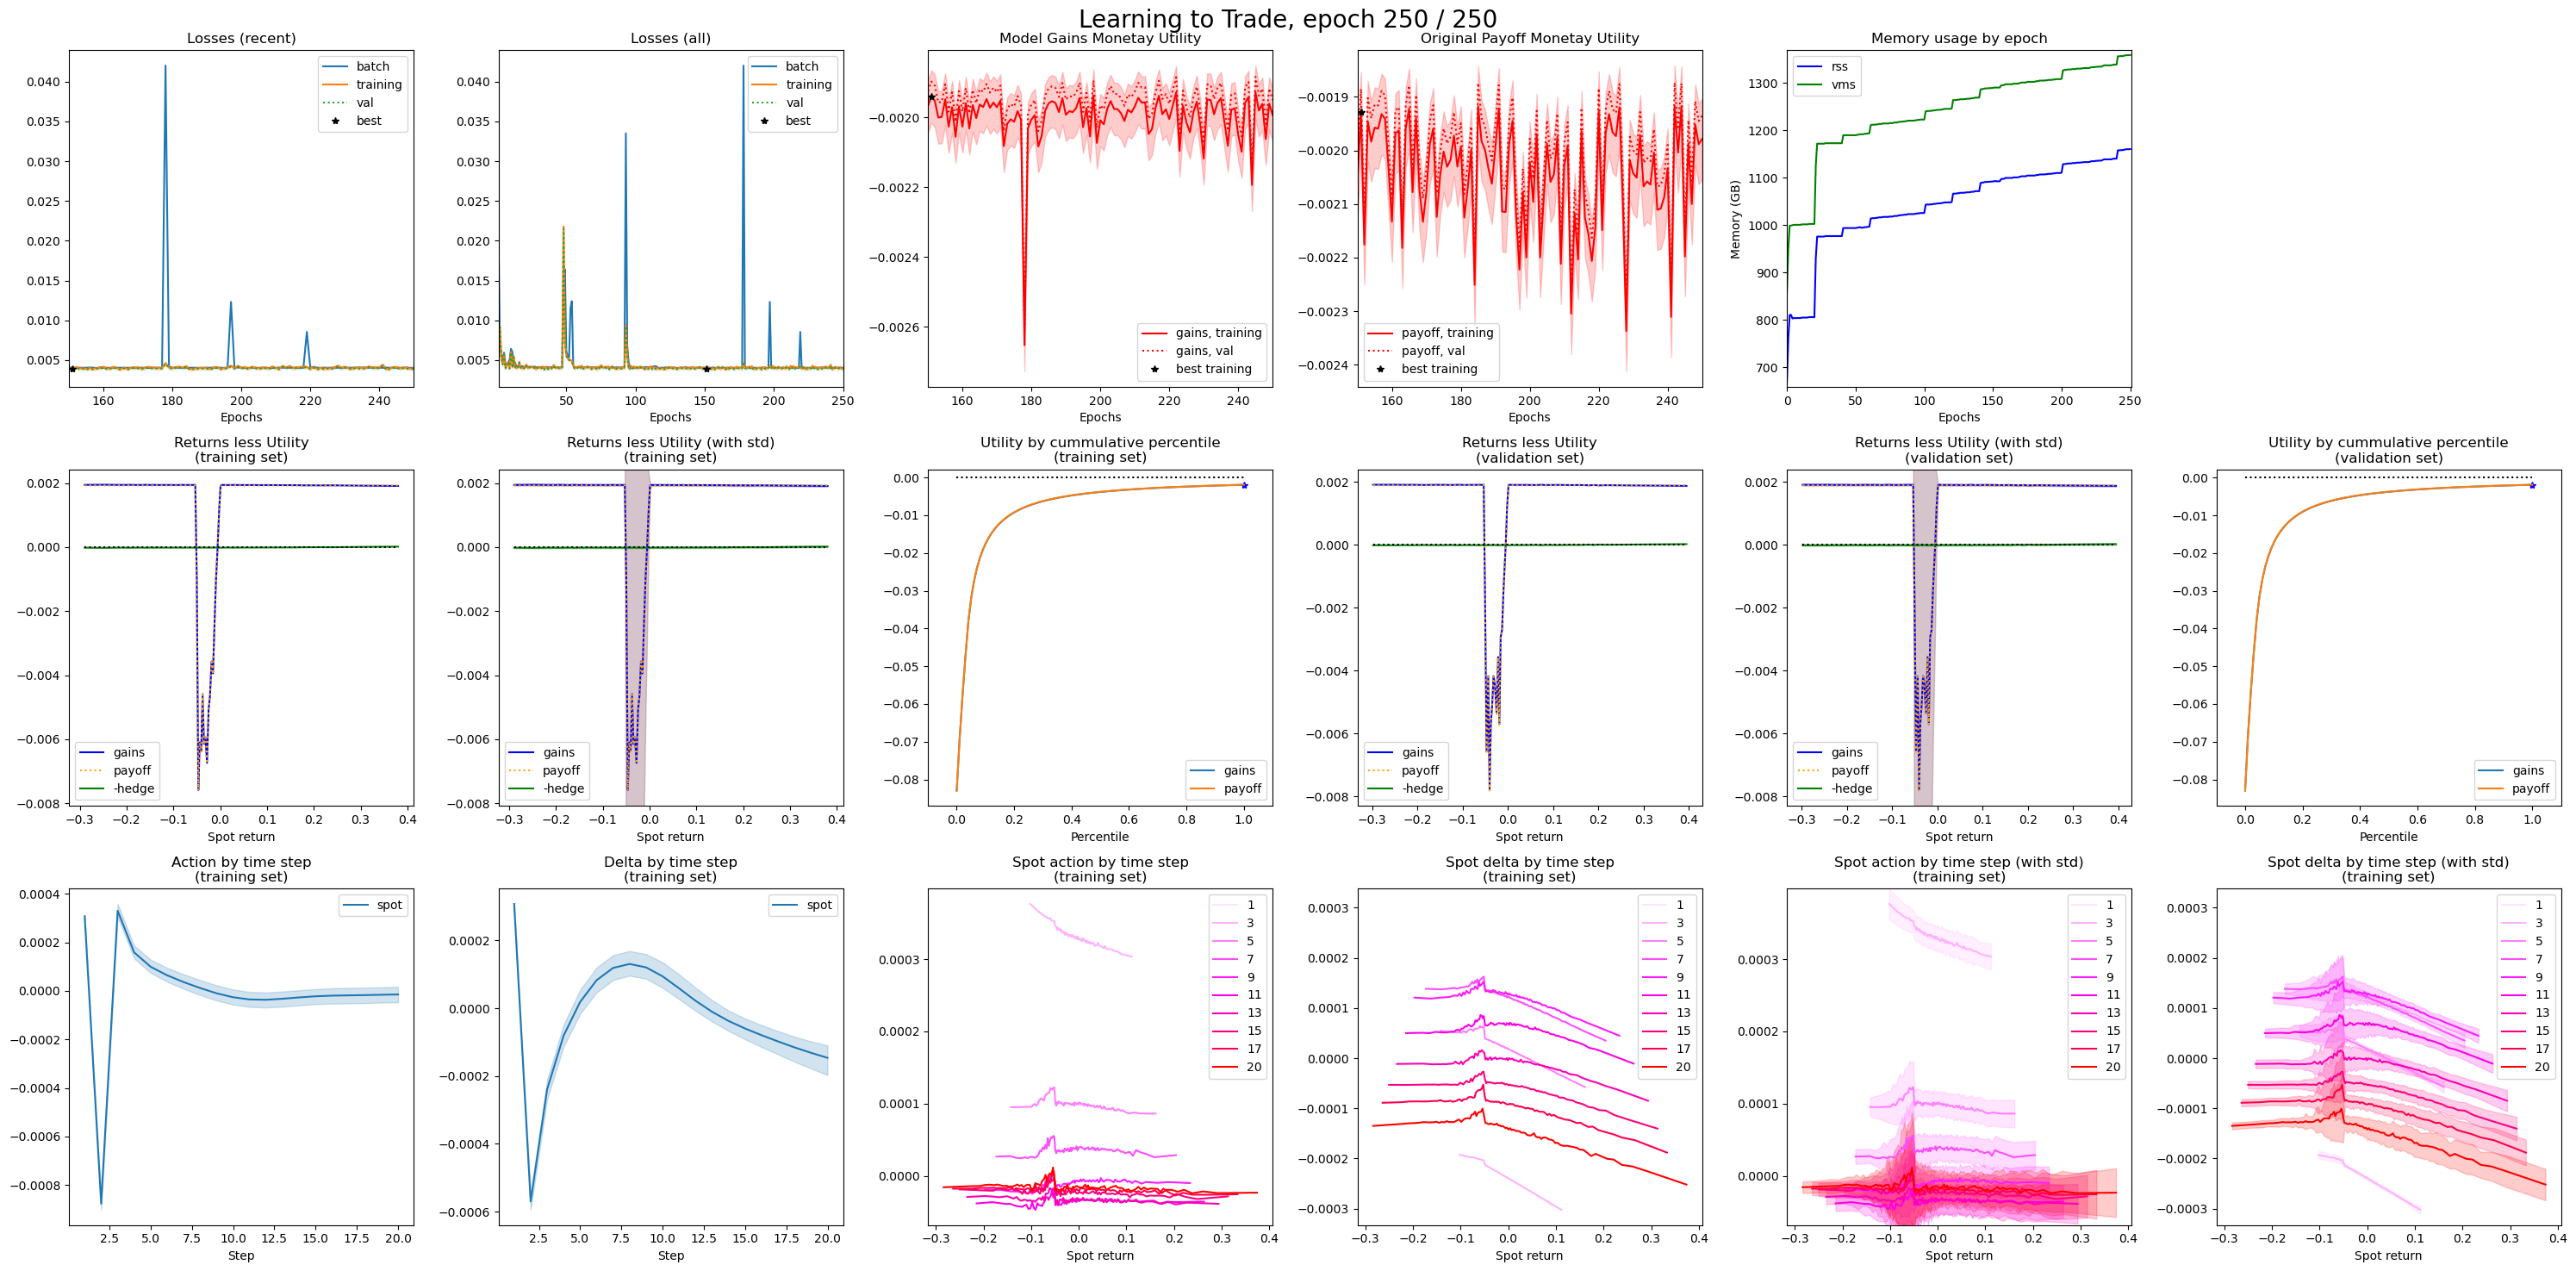

Training 250/250 epochs; 12.03K weights; 20000 samples; 10000 validation samples batch size 32 | initial loss 0.532707 (0.00590944), training 0.00397184 (0.000150252), best 0.00386922 (0.00590944), batch 0.0040393, val 0.00388547 (0.000208576); best epoch 151, last cached 250 | memory used: rss 1160.45M, vms 1358.8M | time elapsed 1:16:10; time per epoch 18s; estimated time remaining 0s | current time: 2023-02-19 15:23:31                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 151
 State of training until epoch 250 cached into C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.deephedging_cache/97ba566c9f5947624b045c48f845985444c7ec8de08f3dd4.pck
 Time: 2023-02-19 15:23:39
Training terminated. Total time taken 27s


In [3]:
# train
# ----
results = pdct()

for k in configs:
    config = configs[k]
    display(Markdown("## Hedging a %s in recurrent '%s' mode" % (payoff_def.name, k)))
    gym = VanillaDeepHedgingGym( config.gym )
    train( gym=gym, world=world, val_world=val_world, config=config.trainer )
    results[k] = npCast( gym(world.tf_data) )
    


## KO Put k=1, b=0.95 Hedging

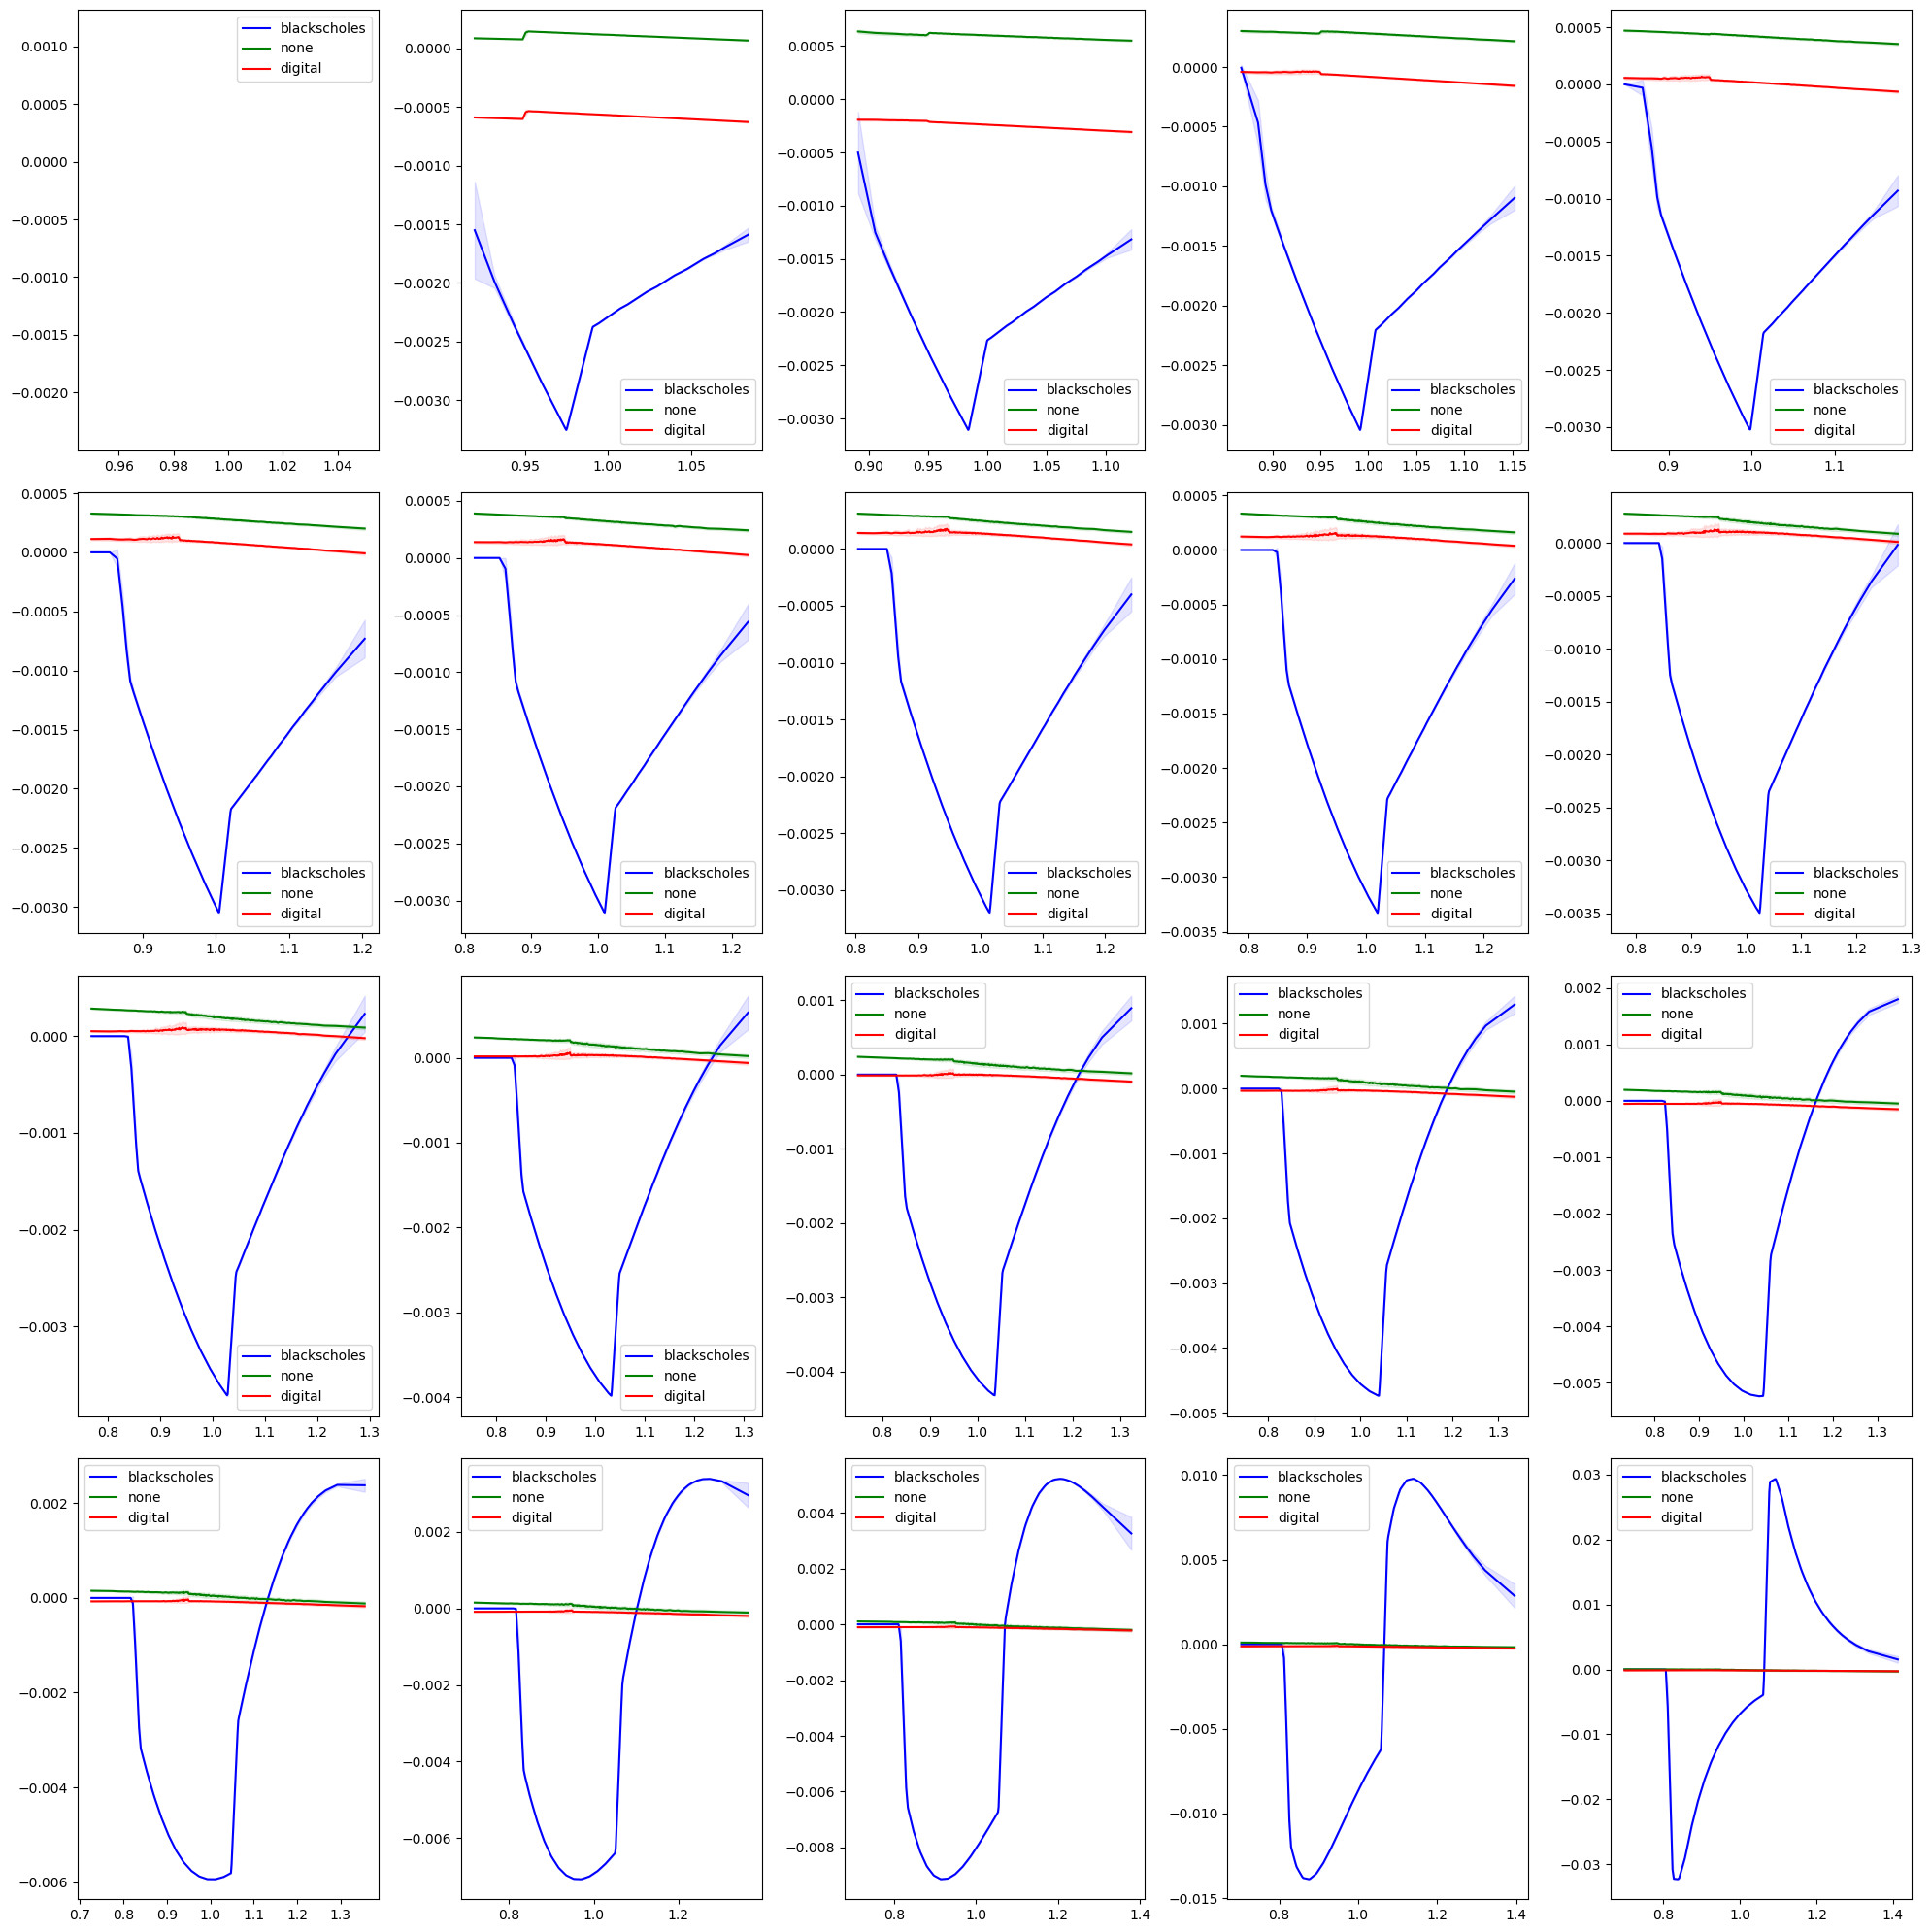

## Terminal KO Put k=1, b=0.95 Profiles

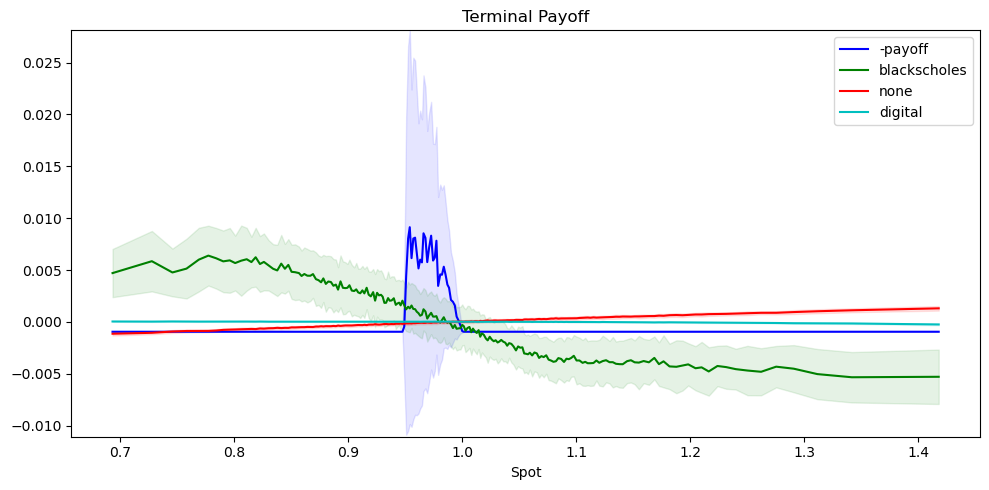

(20000,) (20000,)


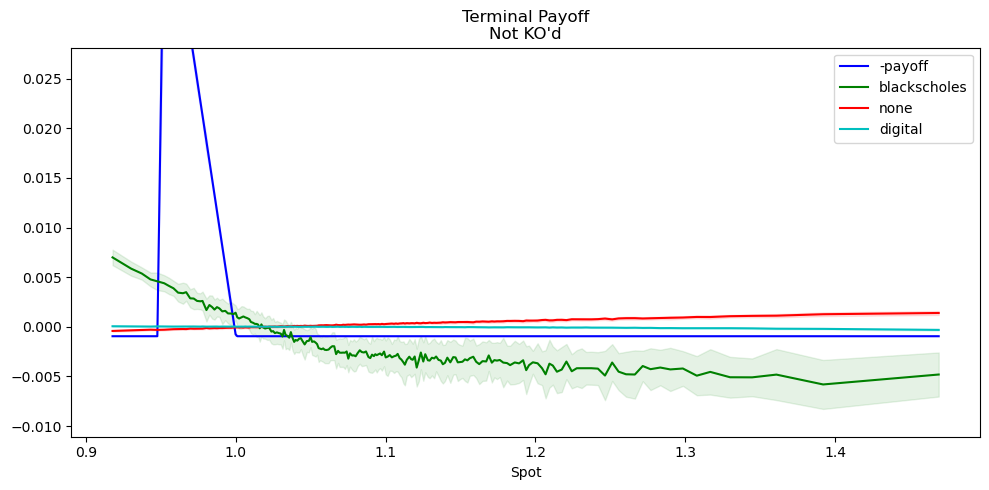

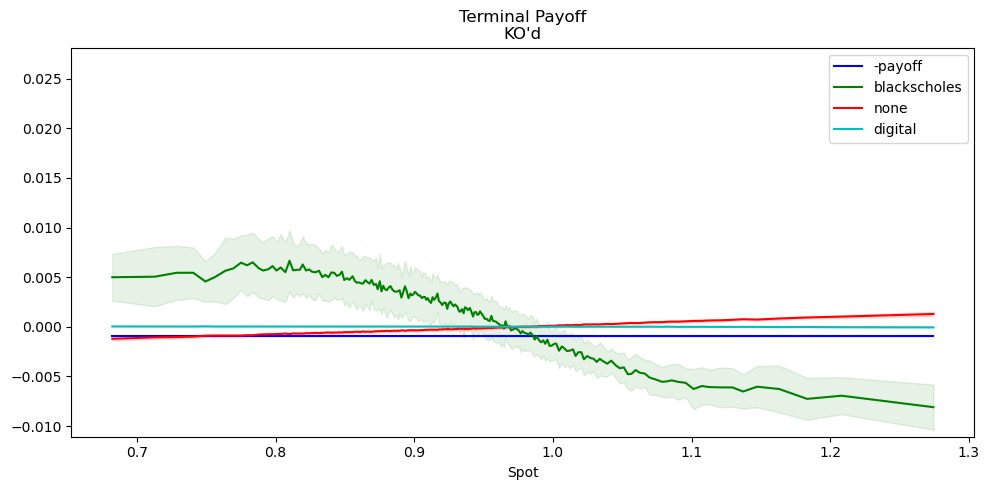

In [4]:
from deephedging.base import npCast, mean_bins
from deephedging.fd import bs_fd
from deephedging.objectives import MonetaryUtility
from cdxbasics.dynaplot import figure, colors_base
from scipy.stats import norm
import math as math
import numpy as np

spots      = world.details.spot_all
hedges     = world.data.market.hedges[:,:,0]
time_left  = world.data.features.per_step.time_left[0,:]
nSteps     = world.nSteps
nSamples   = world.nSamples
nBins      = 200
nBinSteps  = 7
fdstd      = 5.
fdgrid     = 501
times      = world.timeline
ixs        = np.linspace(0,nSteps,nBinSteps,endpoint=True,dtype=np.int32)
vol        = config.world.get_raw("rvol", 0.2)

# collect actions
actions = { k: results[k]['actions'][:,:,0] for k in results }
deltas  = { k: np.cumsum( actions[k], axis=1) for k in results }
pnls    = { k: np.zeros((nSamples,)) for k in results }
pnls['blackscholes'] = np.zeros((nSamples,))
prev_deltas_t  = { k: 0. for k in pnls }

keys_sorted = ['blackscholes'] + list( results.keys() )

# FD pricer
# ---------
def fd_payoff( X, F, t ):
    F     = - np.maximum( strike - X, 0.) if F is None else F
    return np.where( X > barrier, F, 0. )
fd_spots = np.exp( np.linspace(-fdstd,+fdstd,1+2*(fdgrid//2),endpoint=True) * vol * times[-1] )
fd = bs_fd( spots=[fd_spots]*(nSteps+1), times=times, payoff=fd_payoff, vol=vol, cn_factor='implicit')

# plot hedging
# ------------

display(Markdown("## %s Hedging" % payoff_def.name))
fig = figure()

for j in range(nSteps):
    ax_delta  = fig.add_subplot()
   # ax_delta.set_ylim(-1.1,0.1)

    # sort by spot at j, and compute BS refernece
    spot_t    = spots[:,j]
    hedges_t  = hedges[:,j]   # S(T)-S(t_j)
    res_t     = time_left[j]
    dt        = times[j+1] - times[j]
    
    deltas_t  = { k: deltas[k][:,j] for k in deltas }
    deltas_t['blackscholes'] \
              = fd[j].bump_delta( spot_t, vol * math.sqrt(dt) )
    pnls      = { k: pnls[k] + deltas_t[k] * hedges_t for k in pnls }

    # plot
    ixs       = np.argsort(spot_t)
    spot_t    = spot_t[ixs]
    deltas_t  = { k: deltas_t[k][ixs] for k in deltas_t }
    
    x_mean    = mean_bins( spot_t, bins=nBins, weights=world.sample_weights, return_std = False )
    colors    = colors_base()
    for k in keys_sorted:
        mean, std = mean_bins( deltas_t[k], bins=nBins, weights=world.sample_weights, return_std = True )
        color     = next(colors)
        ax_delta.plot( x_mean, mean, label=k, color=color)
        ax_delta.fill_between( x_mean, mean-std, mean+std, color=color, alpha=0.1 )

    ax_delta.legend()
    
fig.render()
fig.close()

# terminal
# --------

display(Markdown("## Terminal %s Profiles" % payoff_def.name))

spots    = world.details.spot_all
payoff   = world.data.market.payoff
notko    = world.data.features.per_step.payoff_features[:,-1]
payoff   = payoff - np.mean( payoff )

spot_ret = spots[:,-1]
ixs      = np.argsort(spot_ret)
spot_ret = spot_ret[ixs]
pnls     = { k : pnls[k][ixs] for k in pnls }
payoff   = payoff[ixs]
notko    = notko[ixs]

# basic
spot_mean = mean_bins( spot_ret, bins=nBins, weights=world.sample_weights, return_std = False )
payoff_mean, payoff_std = mean_bins( payoff, bins=nBins, weights=world.sample_weights, return_std = True )

fig = figure(col_size=10,col_nums=1)
ax = fig.add_subplot()
ax.set_title("Terminal Payoff")
ax.set_xlabel("Spot")

colors = colors_base()
color  = next(colors)
ax.plot( spot_mean, -payoff_mean, label="-payoff", color=color)
ax.fill_between( spot_mean, -payoff_mean-payoff_std, -payoff_mean+payoff_std , color=color, alpha=0.1 )
_min = np.min(-payoff_mean-payoff_std)
_max = np.max(-payoff_mean+payoff_std)
for k in keys_sorted:
    color = next(colors)
    mean, std = mean_bins( pnls[k], bins=nBins, weights=world.sample_weights, return_std = True )

    ax.plot( spot_mean, mean, label=k, color=color )
    ax.fill_between( spot_mean, mean-std, mean+std, color=color, alpha=0.1 )
    _min = min(np.min(mean),_min)
    _max = max(np.max(mean),_max)

ax.legend()
dm = max(_max - _min, 0.001)
_max == dm*0.005
_min -= dm*0.005
ax.set_ylim(_min,_max)
fig.render()
fig.close()

# not KO'd
print(spot_ret.shape, notko.shape)
spot_mean = mean_bins( spot_ret[notko > 0.], bins=nBins, weights=world.sample_weights, return_std = False )
payoff_mean, payoff_std = mean_bins( payoff[notko > 0.], bins=nBins, weights=world.sample_weights, return_std = True )

fig = figure(col_size=10,col_nums=1)
ax = fig.add_subplot()
ax.set_title("Terminal Payoff\nNot KO'd")
ax.set_xlabel("Spot")

colors = colors_base()
color  = next(colors)
ax.plot( spot_mean, -payoff_mean, label="-payoff", color=color)
ax.fill_between( spot_mean, -payoff_mean-payoff_std, -payoff_mean+payoff_std , color=color, alpha=0.1 )
for k in keys_sorted:
    color = next(colors)
    mean, std = mean_bins( pnls[k][notko > 0.], bins=nBins, weights=world.sample_weights, return_std = True )

    ax.plot( spot_mean, mean, label=k, color=color )
    ax.fill_between( spot_mean, mean-std, mean+std, color=color, alpha=0.1 )

ax.legend()
ax.set_ylim(_min,_max)
fig.render()
fig.close()

# KO'd
spot_mean = mean_bins( spot_ret[notko < 1.], bins=nBins, weights=world.sample_weights, return_std = False )
payoff_mean, payoff_std = mean_bins( payoff[notko < 1.], bins=nBins, weights=world.sample_weights, return_std = True )

fig = figure(col_size=10,col_nums=1)
ax = fig.add_subplot()
ax.set_title("Terminal Payoff\nKO'd")
ax.set_xlabel("Spot")

colors = colors_base()
color  = next(colors)
ax.plot( spot_mean, -payoff_mean, label="-payoff", color=color)
ax.fill_between( spot_mean, -payoff_mean-payoff_std, -payoff_mean+payoff_std , color=color, alpha=0.1 )
for k in keys_sorted:
    color = next(colors)
    mean, std = mean_bins( pnls[k][notko < 1.], bins=nBins, weights=world.sample_weights, return_std = True )

    ax.plot( spot_mean, mean, label=k, color=color )
    ax.fill_between( spot_mean, mean-std, mean+std, color=color, alpha=0.1 )

ax.legend()
ax.set_ylim(_min,_max)
fig.render()
fig.close()



## Utilities for KO Put k=1, b=0.95

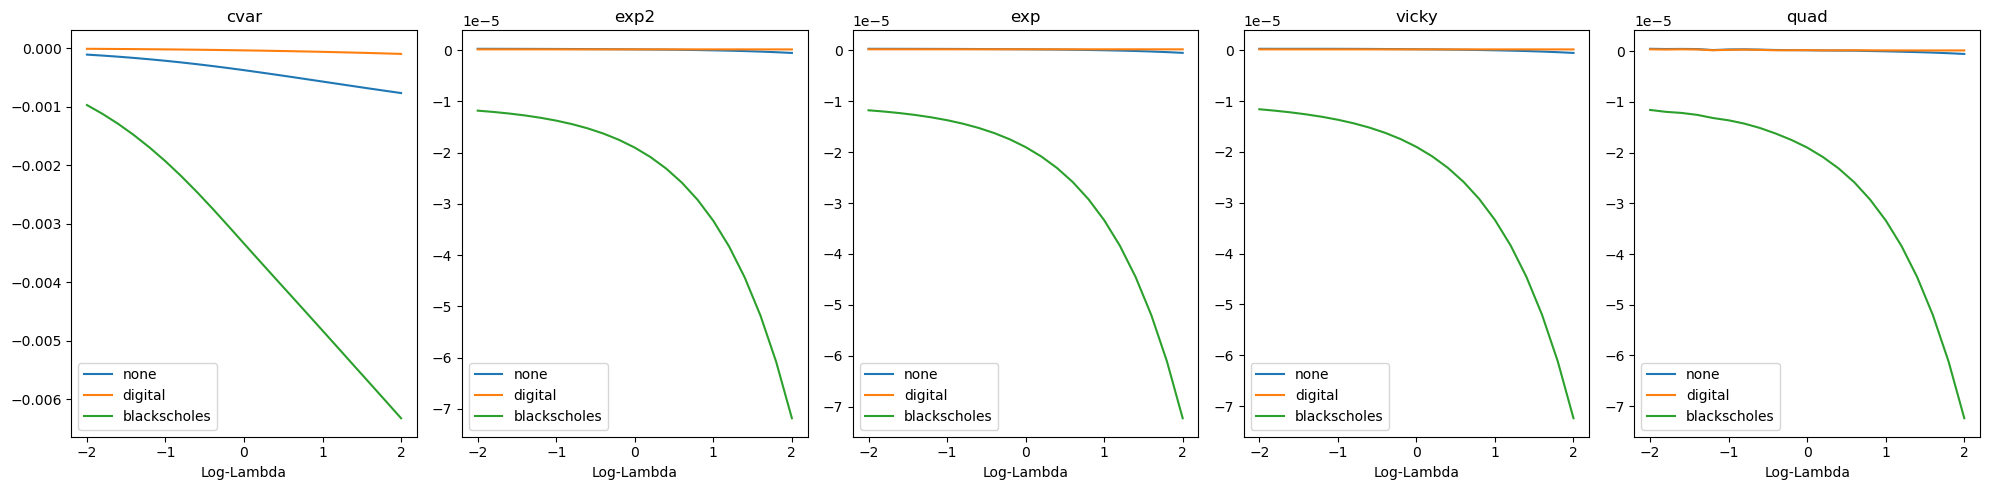

In [7]:
from deephedging.objectives import oce_utility
from cdxbasics.dynaplot import figure, colors_tableau

display(Markdown("## Utilities for %s" % payoff_def.name))

utilities = ['cvar', 'exp2', 'exp', 'vicky', 'quad' ]
lambdas  = np.exp(np.linspace( -2.,2., 21, endpoint=True) )

fig = figure()
axs = dict()
for util in utilities:
    ax  = fig.add_subplot()
    ax.set_title(util)
    ax.set_xlabel("Log-Lambda")
    axs[util] = ax
fig.render()


for util in utilities:
    ax  = axs[util]
    
    colors = colors_tableau()
    
    for k in pnls:
        pnl = pnls[k]
        us  = [ oce_utility(util, lmnda, pnl ) for lmnda in lambdas ]

        ax.plot( np.log(lambdas), us, next(colors), label=k )

    ax.legend()
    fig.render()
    
fig.close()




In [ ]:
print(config.usage_report())